# Assessing quality of assemblies
There are assemblies for nine samples being assessed here.

These samples have >= 30x coverage of PacBio CCS. As well as good coverage Illumina and Nanopore.

There are five assembly tools being analysed, with an assembly for each Nanopore and PacBio. Except for Spades, which takes all sequencing technologies at once.

The polishing is done in two steps:
1. Polish assembly with the long reads it was made from using `racon`
2. Polish the output of `racon` with Illumina using `pilon` until there is no more changes made to the assembly.

In [78]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import DefaultDict
import seaborn as sns
from pathlib import Path
from collections import defaultdict
from dataclasses import dataclass

sns.set_style("darkgrid")
FIGSIZE = (13, 8)

In [79]:
@dataclass(eq=True, frozen=True)
class Sample:
    name: str
    assembler: str
    technology: str
    is_polished: bool
    
    @staticmethod
    def from_path(path: Path) -> "Sample":
        parts = path.parts
        is_polished = "polished" in path.name
        return Sample(
            name = parts[-5],  # we index from end in case starting path is further up dirtree
            assembler = parts[-4],
            technology = parts[-3],
            is_polished = is_polished
        )

In [80]:
results_dir = Path("../results")
assessment_files = list(results_dir.rglob("*.json"))
ale_files = list(results_dir.rglob("*.aggregated.ale"))

In [81]:
len(assessment_files)

162

In [82]:
len(ale_files)

18

In [83]:
scores: DefaultDict[Sample, float] = defaultdict(Sample)
for file in ale_files:
    with file.open() as fh:
        for line in map(str.strip, fh):
            path, score = line.split(":")
            sample = Sample.from_path(Path(path))
            score = float(score)
            scores[sample] = score

In [84]:
data = []

In [85]:
for file in assessment_files:
    sample = Sample.from_path(file)
    arr = [
        sample.name,
        sample.assembler,
        sample.technology,
        sample.is_polished,
    ]
    arr.append(scores[sample])
    d = json.loads(file.read_text())
    mapq = d["mapping_quality_stats"]
    pileup = d["pileup_stats"]
    arr.extend([
        pileup["percent_pileup_disagree"],
        pileup["total_disagreements"],
        pileup["total_pileup_positions"],
        [
            mapq["min"], mapq["25%"], mapq["50%"], mapq["75%"], mapq["max"]
        ],
        mapq["mean"],
        mapq["std"]
    ])
    data.append(arr)

In [86]:
columns = [
    "sample",
    "assembler",
    "technology",
    "is_polished",
    "ale_score",
    "disagree_rate",
    "disagreements",
    "total_positions",
    "mapq_percentiles",
    "mapq_mean",
    "mapq_stdev",
]

In [94]:
keys = columns[:4]
df = pd.DataFrame(data, columns=columns)
# df.set_index(keys, drop=False, inplace=True, verify_integrity=True)
h37rv_len = 4411532
df["relative_total_length"] = np.absolute((df["total_positions"] - h37rv_len) / 1000)

# ALE score
> [ALE: a generic assembly likelihood evaluation framework for assessing the accuracy of genome and metagenome assemblies][ale_paper]

We are using `ALE` here to assess which of the assemblies is the most accurate (has the highest ALE score). For a rigorous definition of the ALE score, refer to the [methods section][ale_methods].

Of note:

> The ALE score can be used to compare two different assemblies of the same genome, forumla and forumla⁠. Call forumla⁠, the ALE score of the first assembly, and forumla⁠, the ALE score of the second, both generated from the same set of reads forumla⁠. The difference of these scores is then given by the equation  

\begin{equation*}
A_1 - A_2 = \log{\frac{P(S_1|R)}{P(S_2|R)}}
\end{equation*}

> The assembly with the higher ALE score is also the one with the larger probability of being correct. Moreover, the difference between two assemblies’ ALE scores describes their relative probabilities of correctness. Below, we refer to the ALE score more precisely as the total ALE score, to differentiate it from the sub-scores (described later in the text) used to construct it.

> Although the ALE score can be reported as a standalone value, this is made possible only to facilitate comparisons with other assemblies of the same genome. We emphasize that the ALE score is a comparative measure and should not be used to judge the quality of a single assembly in isolation

**So, we are looking to see what assembly has the *highest* ALE score.**

[ale_paper]: https://doi.org/10.1093/bioinformatics/bts723
[ale_methods]: https://academic.oup.com/bioinformatics/article/29/4/435/199222#130434587

Now because the ALE scores are only relevant *within* the same sample, we will need to normalise them for each sample. We do this by taking each sample's maximum score and subtracting all other scores (for the sample) from it.

In [95]:
df["norm_ale_score"] = df.groupby("sample")["ale_score"].transform(lambda x: x.max() - x)   

Let's take a look at which combinations have the highest ALE score for each sample.

In [137]:
df.query("norm_ale_score == 0")

,sample,assembler,technology,is_polished,ale_score,disagree_rate,disagreements,total_positions,mapq_percentiles,mapq_mean,mapq_stdev,relative_total_length,norm_ale_score
8,mada_1-2,flye,nanopore,True,-7.292737e+08,5.390014,243054,4509339,"[0.0, 0.0, 60.0, 60.0, 60.0]",33.069767,29.232064,97.807,0.0
25,mada_104,flye,pacbio,False,-4.640459e+07,0.616183,27187,4412164,"[0.0, 60.0, 60.0, 60.0, 60.0]",58.969100,7.436795,0.632,0.0
43,mada_101,flye,pacbio,False,-2.921920e+07,0.334272,14754,4413772,"[0.0, 60.0, 60.0, 60.0, 60.0]",59.058180,7.182343,2.240,0.0
59,mada_1-44,unicycler,nanopore,False,-2.049206e+07,0.976541,43106,4414150,"[0.0, 60.0, 60.0, 60.0, 60.0]",59.295854,6.161524,2.618,0.0
78,mada_130,flye,pacbio,False,-2.751428e+07,0.711394,31402,4414152,"[0.0, 60.0, 60.0, 60.0, 60.0]",58.902324,7.796930,2.620,0.0
91,mada_132,spades,pacbio,True,-1.721459e+07,0.920840,40413,4388708,"[0.0, 60.0, 60.0, 60.0, 60.0]",59.293211,6.209824,22.824,0.0
110,mada_116,unicycler,pacbio,False,-2.658962e+07,0.434147,19214,4425691,"[0.0, 60.0, 60.0, 60.0, 60.0]",59.072402,7.123947,14.159,0.0
126,mada_125,spades,pacbio,True,-1.848009e+07,0.537077,23702,4413147,"[0.0, 60.0, 60.0, 60.0, 60.0]",59.133411,6.864277,1.615,0.0
144,mada_102,spades,pacbio,False,-1.835982e+07,0.467174,20586,4406491,"[0.0, 60.0, 60.0, 60.0, 60.0]",59.213578,6.552905,5.041,0.0


And to summarise the counts for how many times the **assembler** has the highest ALE score

In [135]:
df.query("norm_ale_score == 0").groupby("assembler")["sample"].count()

assembler
flye         4
spades       3
unicycler    2
Name: sample, dtype: int64

And to summarise the counts for how many times the **technology** has the highest ALE score

In [138]:
df.query("norm_ale_score == 0").groupby("technology")["sample"].count()

technology
nanopore    2
pacbio      7
Name: sample, dtype: int64

And to summarise the counts for how many times the **polished** has the highest ALE score

In [139]:
df.query("norm_ale_score == 0").groupby("is_polished")["sample"].count()

is_polished
False    6
True     3
Name: sample, dtype: int64

/home/michael/.pyenv/versions/3.8.2/envs/head_to_head_pipeline/lib/python3.8/site-packages/seaborn/axisgrid.py:29: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(**kwargs)


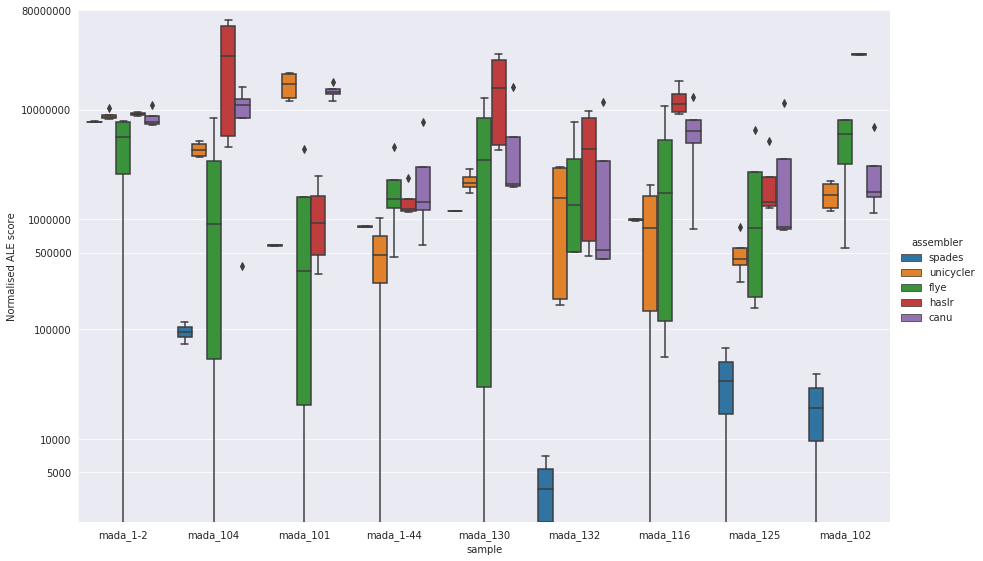

In [127]:
x = "sample"
y = "norm_ale_score"
hue = "assembler"
kind = "box"
aspect = 1.5
height = 8
ax = sns.catplot(
    x=x,
    y=y, 
    hue=hue,
    data=df, 
    kind=kind, 
    aspect=aspect, 
    height=height,
)
ax.set(yscale="log")
log_ticks = [0, 1, 500, 1_000, 5_000, 10_000, 100_000, 500_000, 1_000_000, 10_000_000, 80_000_000]
ylim = (log_ticks[0], log_ticks[-1])
ax.set(yticks=log_ticks, ylim=ylim)
ax.set_axis_labels(x_var=x, y_var="Normalised ALE score")
_ = ax.set_yticklabels(log_ticks)

# Disagreement rate
The first metric we will look at is disagreement rate. This is a "proxy" for per-base accuracy of our assemblies. As we don't have a ground-truth for these samples, we need some kind of metric that gives us an indication of the accuracy.  
Disagreement rate is calculated by mapping Illumina reads (with `bwa mem`) for a given sample to the unpolished and polished assemblies of that sample.

## Plot sample disagreement rate

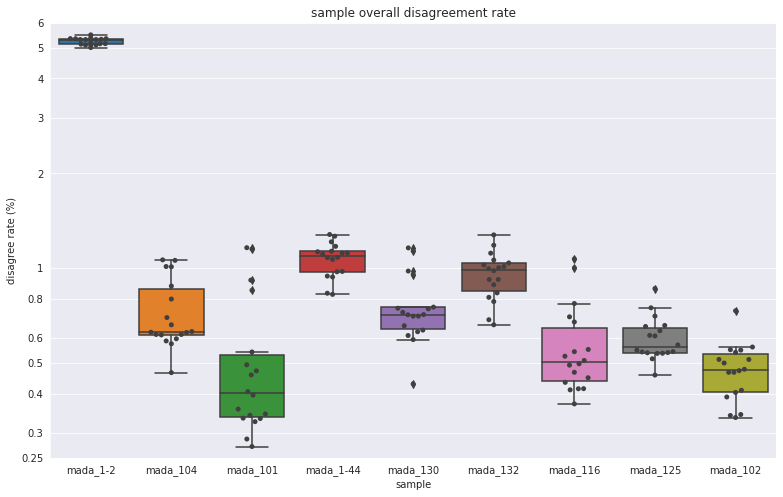

In [148]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x="sample", 
    y="disagree_rate", 
    data=df, 
    ax=ax
)
ax = sns.swarmplot(
    x="sample", 
    y="disagree_rate", 
    data=df, 
    ax=ax,
    dodge=True,
    color="0.25"
)
ax.set(title="sample overall disagreement rate")
ax.set_yscale("log")
ax.set_ylabel("disagree rate (%)")
log_ticks = [0.25, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 2, 3, 4, 5, 6]
ylim = (log_ticks[0], log_ticks[-1])
ax.set(yticks=log_ticks, ylim=ylim)
_ = ax.set_yticklabels(log_ticks)


## Plot sample (un)polished disagreement rate


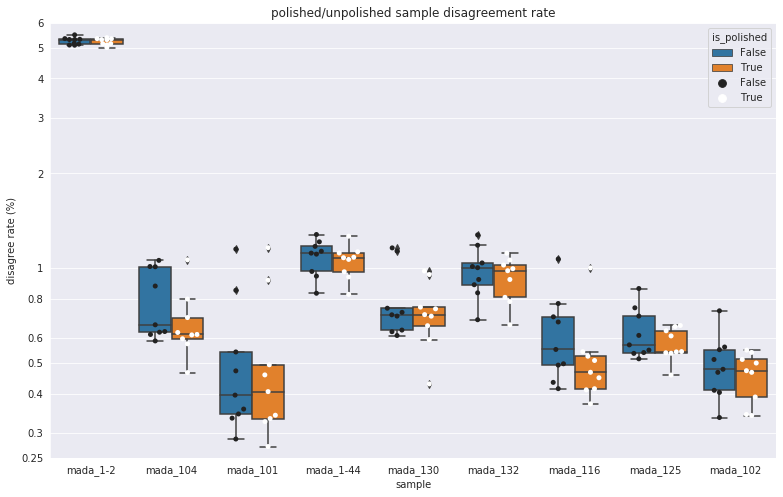

In [161]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x="sample", 
    y="disagree_rate", 
    data=df, 
    hue="is_polished", 
    ax=ax
)
ax = sns.swarmplot(
    x="sample", 
    y="disagree_rate", 
    data=df, 
    hue="is_polished", 
    ax=ax,
    dodge=True,
    color="white"
)
ax.set_yscale("log")
ax.set(title="polished/unpolished sample disagreement rate")
ax.set_ylabel("disagree rate (%)")
log_ticks = [0.25, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 2, 3, 4, 5, 6]
ylim = (log_ticks[0], log_ticks[-1])
ax.set(yticks=log_ticks, ylim=ylim)
_ = ax.set_yticklabels(log_ticks)

So, on the whole, polishing reduces the disagreement rate.


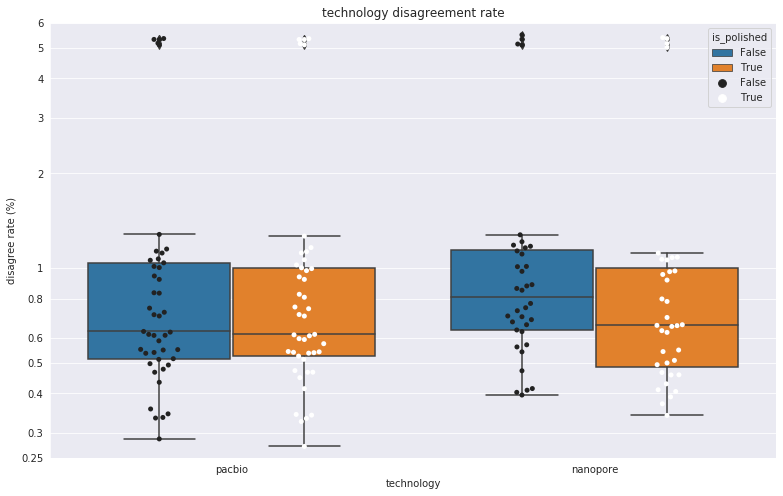

In [159]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x="technology", 
    y="disagree_rate", 
    data=df, 
    hue="is_polished", 
    ax=ax
)
ax = sns.swarmplot(
    x="technology", 
    y="disagree_rate", 
    data=df, 
    hue="is_polished", 
    ax=ax,
    dodge=True,
    color="white"
)
ax.set_yscale("log")
ax.set(title="technology disagreement rate")
ax.set_ylabel("disagree rate (%)")
log_ticks = [0.25, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 2, 3, 4, 5, 6]
ylim = (log_ticks[0], log_ticks[-1])
ax.set(yticks=log_ticks, ylim=ylim)
_ = ax.set_yticklabels(log_ticks)

This shows that polished has much more effect on the nanopore assemblies then it does on the pacbio ones.

## Plot disagreement rate for each assembler

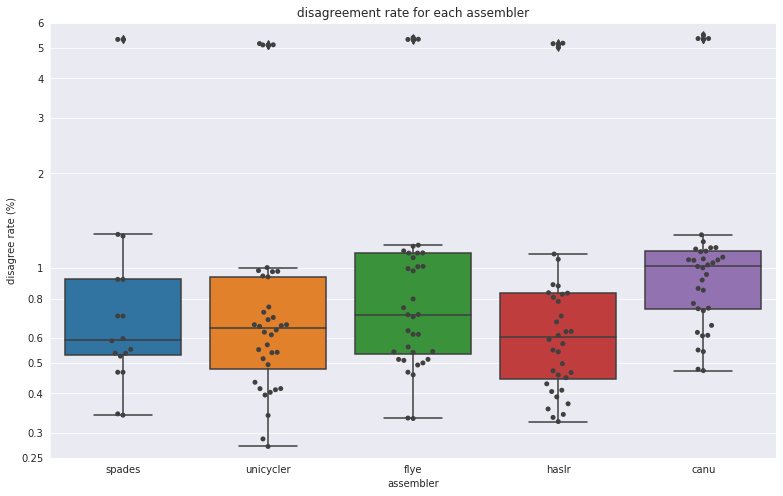

In [152]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x="assembler", 
    y="disagree_rate", 
    data=df, 
    ax=ax
)
ax = sns.swarmplot(
    x="assembler", 
    y="disagree_rate", 
    data=df, 
    ax=ax,
    dodge=True,
    color="0.25"
)
ax.set_yscale("log")
ax.set(title="disagreement rate for each assembler")
ax.set_ylabel("disagree rate (%)")
log_ticks = [0.25, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 2, 3, 4, 5, 6]
ylim = (log_ticks[0], log_ticks[-1])
ax.set(yticks=log_ticks, ylim=ylim)
_ = ax.set_yticklabels(log_ticks)

The only thing we can really say here is that the `canu` assemblies have more disagreements, in general.

## Plot disagreement rate for each assembler, split by technology

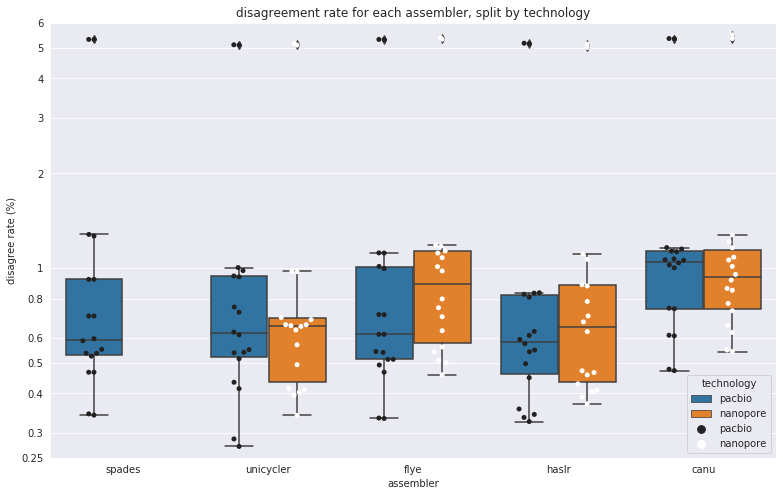

In [154]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x="assembler", 
    y="disagree_rate", 
    hue="technology",
    data=df, 
    ax=ax
)
ax = sns.swarmplot(
    x="assembler", 
    y="disagree_rate", 
    hue="technology",
    data=df, 
    ax=ax,
    dodge=True,
    color="white"
)
ax.set_yscale("log")
ax.set(title="disagreement rate for each assembler, split by technology")
ax.set_ylabel("disagree rate (%)")
log_ticks = [0.25, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 2, 3, 4, 5, 6]
ylim = (log_ticks[0], log_ticks[-1])
ax.set(yticks=log_ticks, ylim=ylim)
_ = ax.set_yticklabels(log_ticks)

Ok. So it's fairly clear that `unicycler` handles nanopore much better than it does pacbio. `flye` is better on pacbio data (v2.7 introduced a new "hifi" mode). `haslr` and `canu` perform about the same on each.

What if we look at each sample split but technology?

## Plot disagreement rate for each sample, split by technology

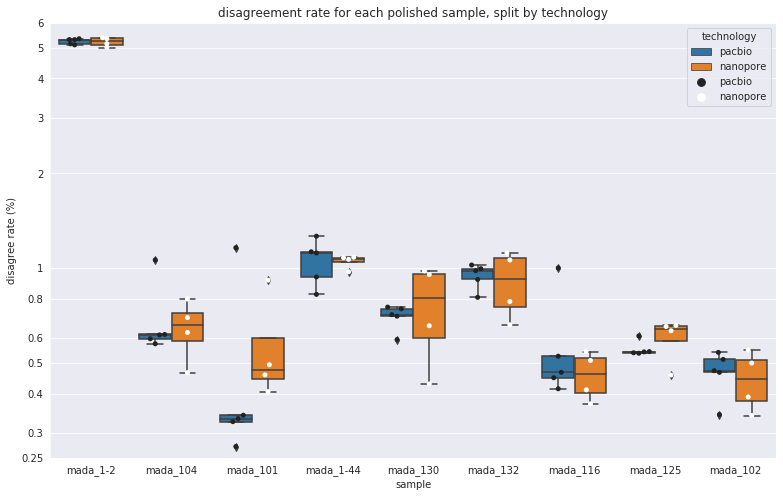

In [157]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x="sample", 
    y="disagree_rate", 
    hue="technology",
    data=df.query("is_polished == True"), 
    ax=ax
)
ax = sns.swarmplot(
    x="sample", 
    y="disagree_rate", 
    hue="technology",
    data=df.query("is_polished == True"), 
    ax=ax,
    dodge=True,
    color="white"
)
ax.set(title="disagreement rate for each polished sample, split by technology")
ax.set_yscale("log")
ax.set_ylabel("disagree rate (%)")
log_ticks = [0.25, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 2, 3, 4, 5, 6]
ylim = (log_ticks[0], log_ticks[-1])
ax.set(yticks=log_ticks, ylim=ylim)
_ = ax.set_yticklabels(log_ticks)

On the whole, pacbio data produces less disagreements. However, there are a couple of samples where it is the same between both, and maybe even one where nanopore appears to be better (mada_102).

Let's have a look at the same plot, but the unpolished data.

## Plot disagreement rate for each sample (**unpolished**), split by technology


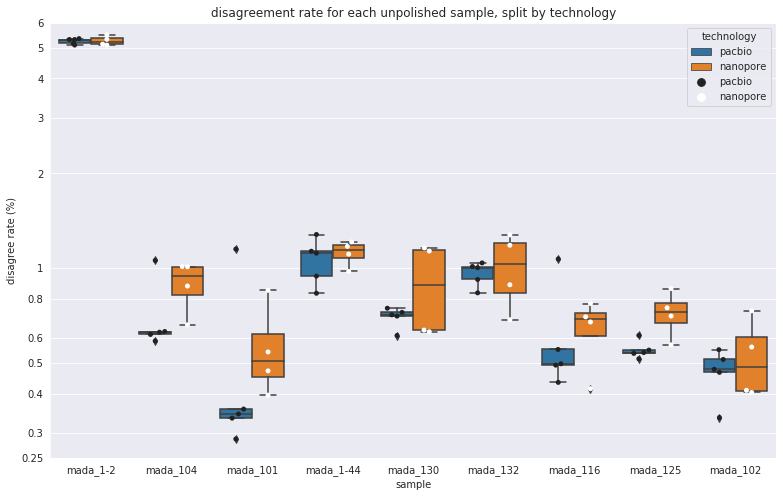

In [158]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x="sample", 
    y="disagree_rate", 
    hue="technology",
    data=df.query("is_polished == False"), 
    ax=ax
)
ax = sns.swarmplot(
    x="sample", 
    y="disagree_rate", 
    hue="technology",
    data=df.query("is_polished == False"), 
    ax=ax,
    dodge=True,
    color="white"
)
ax.set(title="disagreement rate for each unpolished sample, split by technology")
ax.set_yscale("log")
ax.set_ylabel("disagree rate (%)")
log_ticks = [0.25, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 2, 3, 4, 5, 6]
ylim = (log_ticks[0], log_ticks[-1])
ax.set(yticks=log_ticks, ylim=ylim)
_ = ax.set_yticklabels(log_ticks)

Ok, so moral of the story: PacBio (CCS) assemblies are better than nanopore if you can't polish.

Let's have a look at each assembler, split by sample

## Plot disagreement rate for each assembler, split by sample

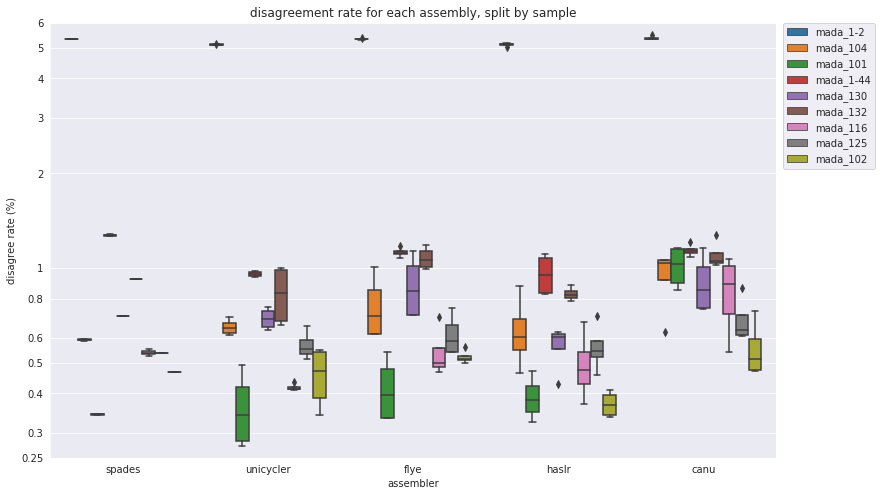

In [163]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x="assembler", 
    y="disagree_rate", 
    hue="sample",
    data=df, 
    ax=ax
)
ax.set(title="disagreement rate for each assembly, split by sample")
ax.set_yscale("log")
ax.set_ylabel("disagree rate (%)")
log_ticks = [0.25, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 2, 3, 4, 5, 6]
ylim = (log_ticks[0], log_ticks[-1])
ax.set(yticks=log_ticks, ylim=ylim)
_ = ax.set_yticklabels(log_ticks)
# Put the legend out of the figure
_ = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

## One plot to rule them all

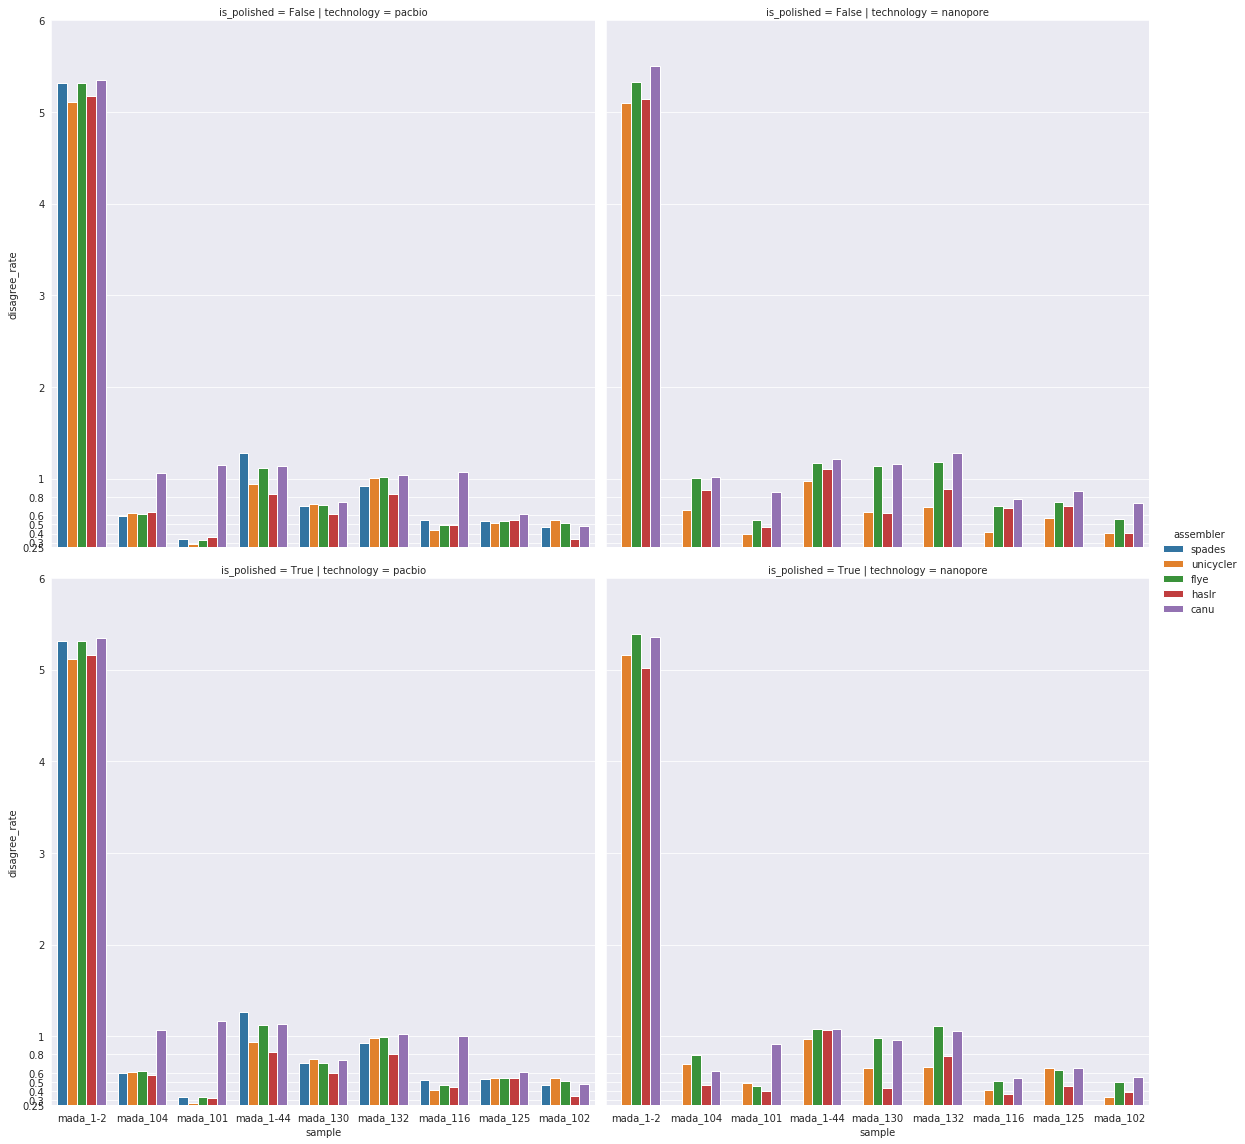

In [166]:
ax = sns.catplot(
    x="sample", 
    y="disagree_rate", 
    hue="assembler",
    col="technology",
    row="is_polished",
    data=df, 
    kind="bar", 
    aspect=1, 
    height=8
)
log_ticks = [0.25, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 2, 3, 4, 5, 6]
ylim = (log_ticks[0], log_ticks[-1])
ax.set(yticks=log_ticks, ylim=ylim)
_ = ax.set_yticklabels(log_ticks)

### Disagreement rate conclusion
...

# Assembly total length
Relative length here is defined as **the absolute value of the assembly length minus the length of H37Rv**.

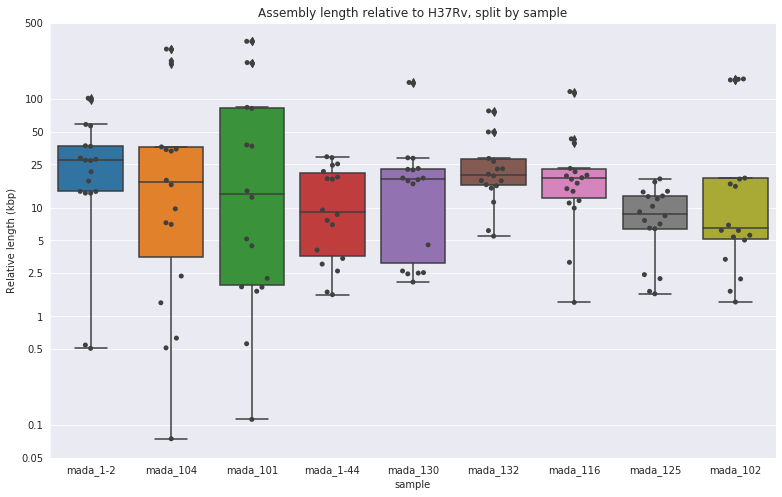

In [177]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x="sample", 
    y="relative_total_length", 
    data=df, 
    ax=ax
)
ax = sns.swarmplot(
    x="sample", 
    y="relative_total_length", 
    data=df, 
    ax=ax,
    dodge=True,
    color="0.25"
)
ax.set(title="Assembly length relative to H37Rv, split by sample")
_ = ax.set_ylabel("Relative length (kbp)")
ax.set_yscale("log")

log_ticks = [0.05, 0.1, 0.5, 1, 2.5, 5, 10, 25, 50, 100, 500]
ax.set_yticks(log_ticks)
_ = ax.set_yticklabels(log_ticks)
_ = ax.set_ylim((log_ticks[0], log_ticks[-1]))

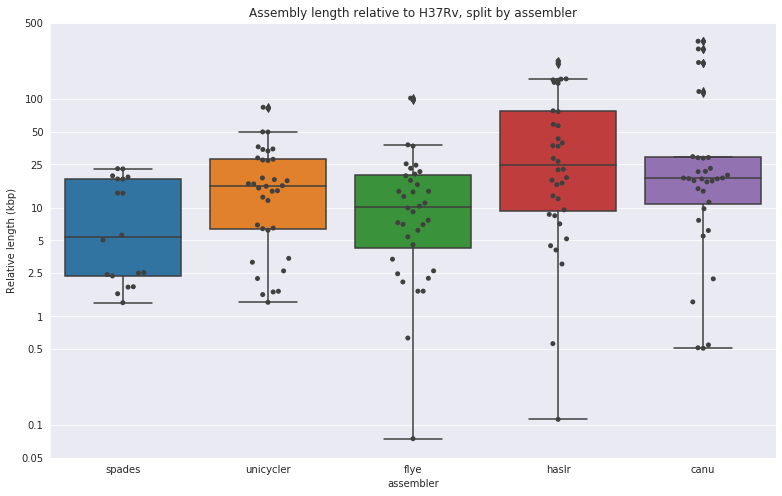

In [178]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x="assembler", 
    y="relative_total_length", 
    data=df, 
    ax=ax
)
ax = sns.swarmplot(
    x="assembler", 
    y="relative_total_length", 
    data=df, 
    ax=ax,
    dodge=True,
    color="0.25"
)
ax.set(title="Assembly length relative to H37Rv, split by assembler")
_ = ax.set_ylabel("Relative length (kbp)")
ax.set_yscale("log")

log_ticks = [0.05, 0.1, 0.5, 1, 2.5, 5, 10, 25, 50, 100, 500]
ax.set_yticks(log_ticks)
_ = ax.set_yticklabels(log_ticks)
_ = ax.set_ylim((log_ticks[0], log_ticks[-1]))

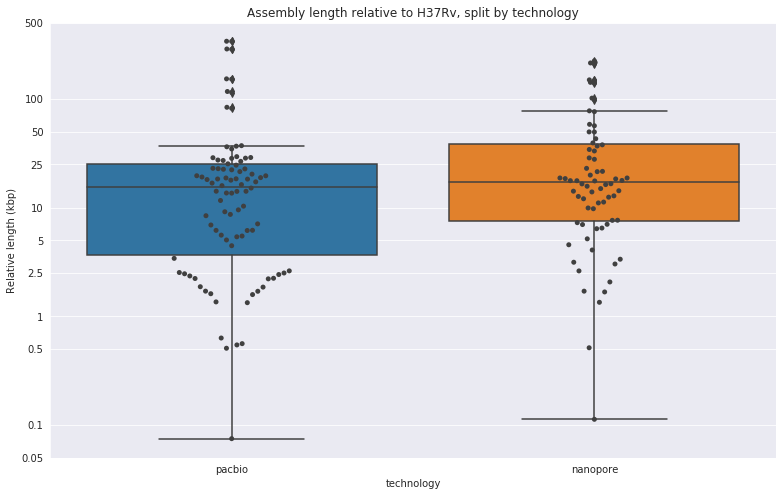

In [179]:
x = "technology"
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x=x, 
    y="relative_total_length", 
    data=df, 
    ax=ax
)
ax = sns.swarmplot(
    x=x, 
    y="relative_total_length", 
    data=df, 
    ax=ax,
    dodge=True,
    color="0.25"
)
ax.set(title="Assembly length relative to H37Rv, split by technology")
_ = ax.set_ylabel("Relative length (kbp)")
ax.set_yscale("log")

log_ticks = [0.05, 0.1, 0.5, 1, 2.5, 5, 10, 25, 50, 100, 500]
ax.set_yticks(log_ticks)
_ = ax.set_yticklabels(log_ticks)
_ = ax.set_ylim((log_ticks[0], log_ticks[-1]))

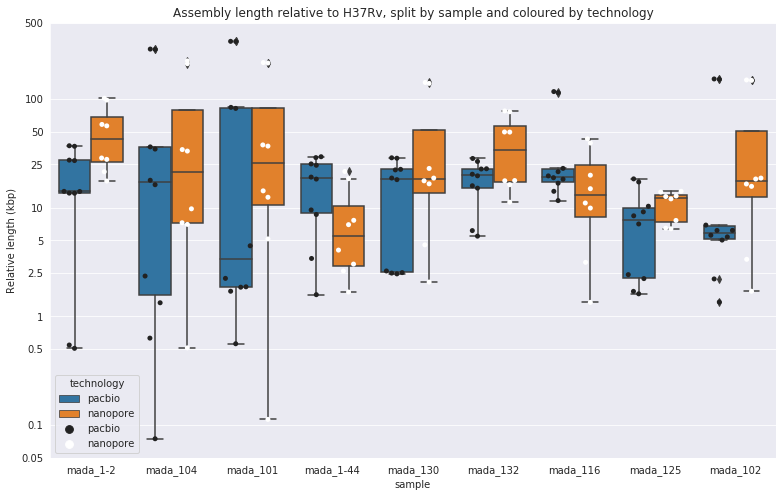

In [180]:
x = "sample"
hue = "technology"
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x=x, 
    y="relative_total_length", 
    data=df, 
    hue=hue,
    ax=ax
)
ax = sns.swarmplot(
    x=x, 
    y="relative_total_length", 
    hue=hue,
    data=df, 
    ax=ax,
    dodge=True,
    color="white"
)
ax.set(title="Assembly length relative to H37Rv, split by sample and coloured by technology")
_ = ax.set_ylabel("Relative length (kbp)")
ax.set_yscale("log")

log_ticks = [0.05, 0.1, 0.5, 1, 2.5, 5, 10, 25, 50, 100, 500]
ax.set_yticks(log_ticks)
_ = ax.set_yticklabels(log_ticks)
_ = ax.set_ylim((log_ticks[0], log_ticks[-1]))

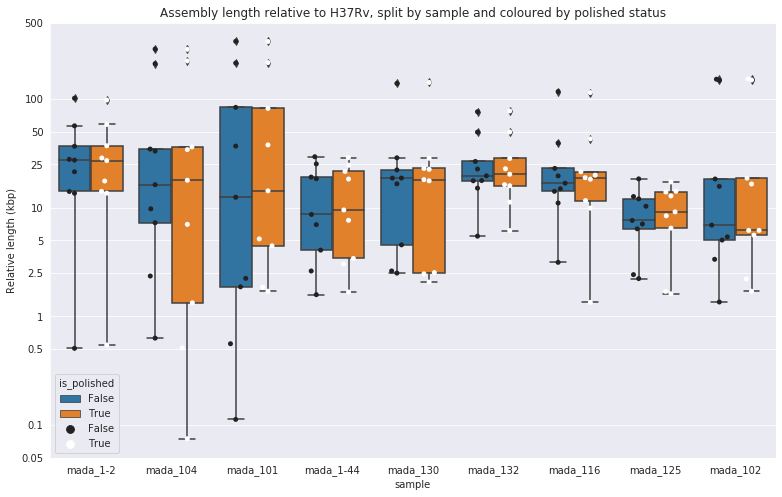

In [181]:
x = "sample"
hue = "is_polished"
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x=x, 
    y="relative_total_length", 
    data=df, 
    hue=hue,
    ax=ax
)
ax = sns.swarmplot(
    x=x, 
    y="relative_total_length", 
    hue=hue,
    data=df, 
    ax=ax,
    dodge=True,
    color="white"
)
ax.set(title="Assembly length relative to H37Rv, split by sample and coloured by polished status")
_ = ax.set_ylabel("Relative length (kbp)")
ax.set_yscale("log")

log_ticks = [0.05, 0.1, 0.5, 1, 2.5, 5, 10, 25, 50, 100, 500]
ax.set_yticks(log_ticks)
_ = ax.set_yticklabels(log_ticks)
_ = ax.set_ylim((log_ticks[0], log_ticks[-1]))

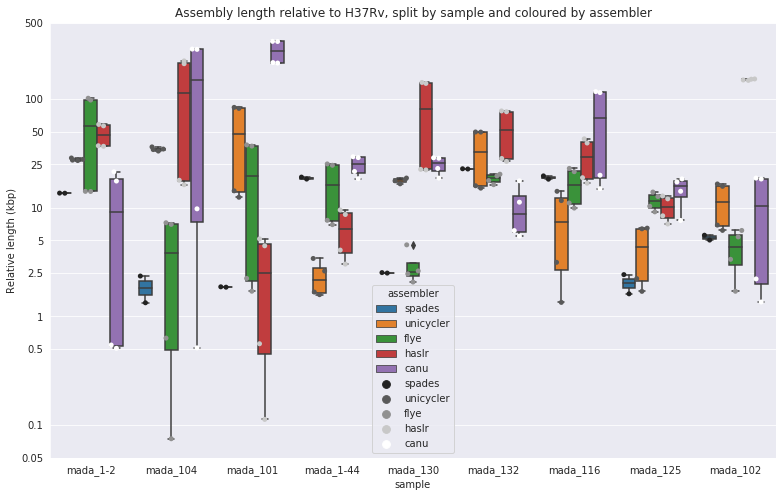

In [183]:
x = "sample"
y= "relative_total_length"
hue = "assembler"
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x=x, 
    y=y, 
    data=df, 
    hue=hue,
    ax=ax
)
ax = sns.swarmplot(
    x=x, 
    y=y, 
    hue=hue,
    data=df, 
    ax=ax,
    dodge=True,
    color="white"
)
ax.set(title="Assembly length relative to H37Rv, split by sample and coloured by assembler")
_ = ax.set_ylabel("Relative length (kbp)")
ax.set_yscale("log")

log_ticks = [0.05, 0.1, 0.5, 1, 2.5, 5, 10, 25, 50, 100, 500]
ax.set_yticks(log_ticks)
_ = ax.set_yticklabels(log_ticks)
_ = ax.set_ylim((log_ticks[0], log_ticks[-1]))

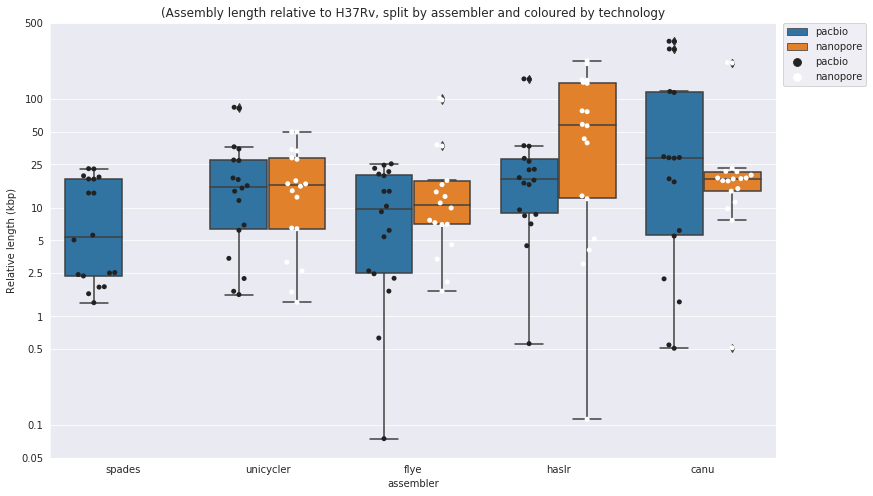

In [184]:
x = "assembler"
y= "relative_total_length"
hue = "technology"
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x=x, 
    y=y, 
    data=df, 
    hue=hue,
    ax=ax
)
ax = sns.swarmplot(
    x=x, 
    y=y, 
    hue=hue,
    data=df, 
    ax=ax,
    dodge=True,
    color="white"
)
ax.set(title="(Assembly length relative to H37Rv, split by assembler and coloured by technology")
_ = ax.set_ylabel("Relative length (kbp)")
ax.set_yscale("log")

log_ticks = [0.05, 0.1, 0.5, 1, 2.5, 5, 10, 25, 50, 100, 500]
ax.set_yticks(log_ticks)
_ = ax.set_yticklabels(log_ticks)
_ = ax.set_ylim((log_ticks[0], log_ticks[-1]))
# Put the legend out of the figure
_ = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

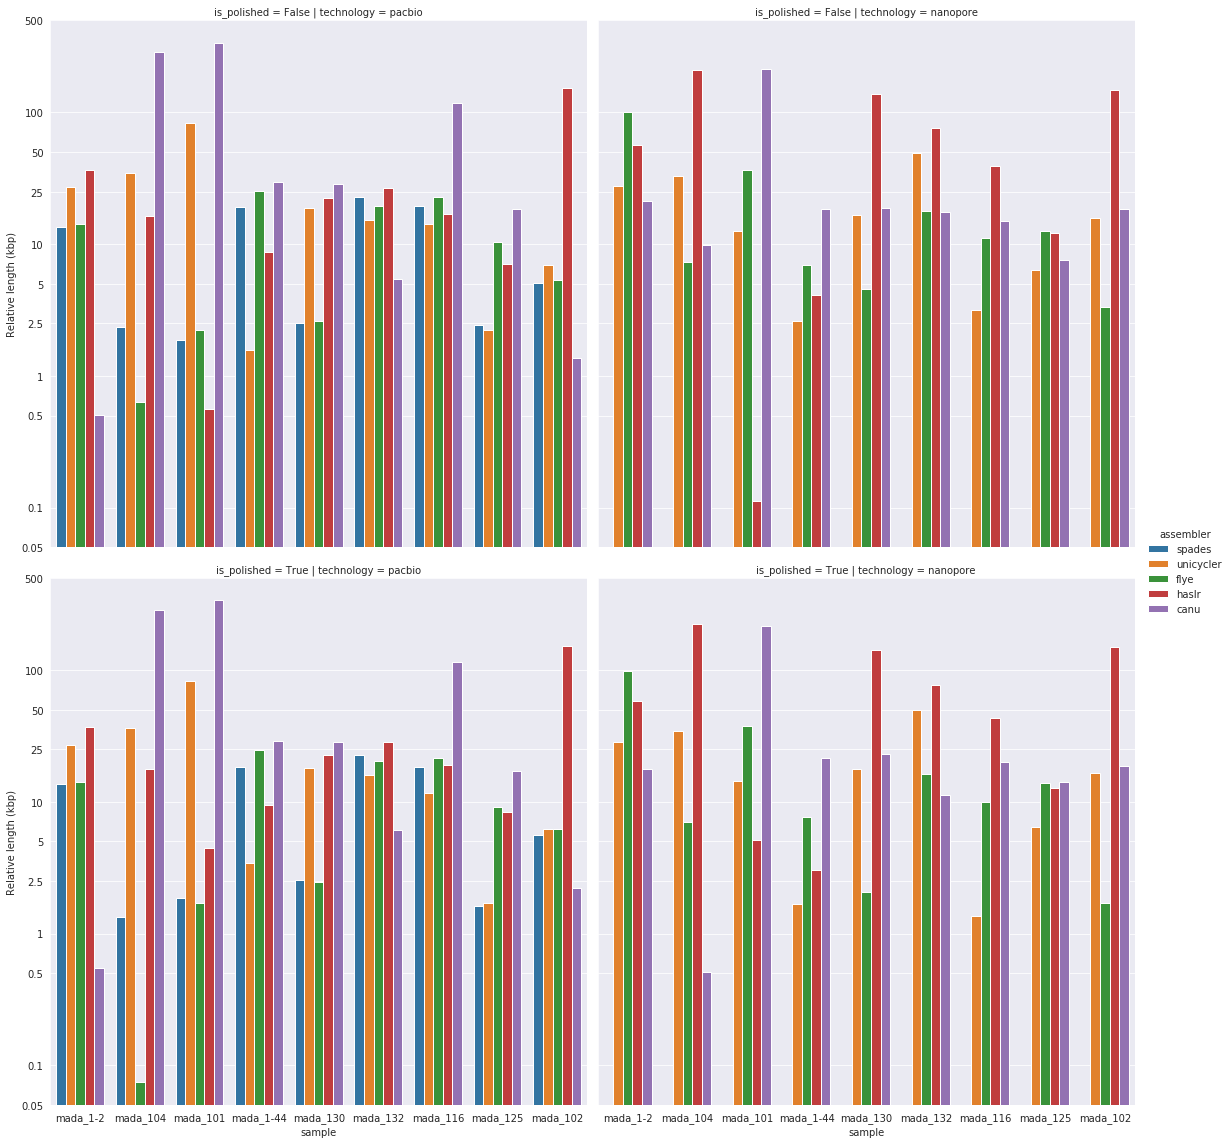

In [185]:
x = "sample"
y = "relative_total_length"
hue = "assembler"
col = "technology"
row = "is_polished"
ax = sns.catplot(
    x=x, 
    y=y, 
    hue=hue,
    row=row,
    col=col,
    data=df, 
    kind="bar", 
    aspect=1, 
    height=8
)
ax.set(yscale="log")
log_ticks = [0.05, 0.1, 0.5, 1, 2.5, 5, 10, 25, 50, 100, 500]
ylim = (log_ticks[0], log_ticks[-1])
ax.set(yticks=log_ticks, ylim=ylim)
ax.set_axis_labels(x_var=x, y_var="Relative length (kbp)")
_ = ax.set_yticklabels(log_ticks)

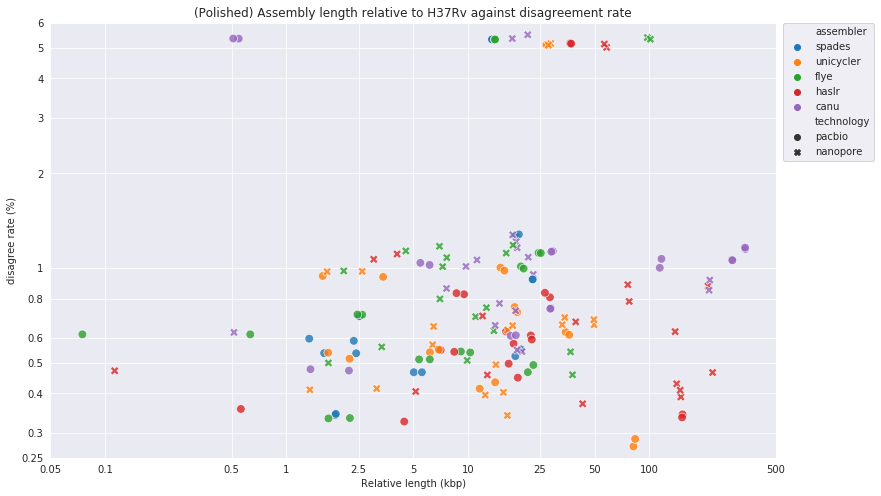

In [188]:
x = "relative_total_length"
y = "disagree_rate"
hue = "assembler"
style = "technology"
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.scatterplot(
    x=x, 
    y=y, 
    data=df, 
    hue=hue,
    style=style,
    ax=ax,
    s=75,
    alpha=0.8
)
ax.set(title="Assembly length relative to H37Rv against disagreement rate")
_ = ax.set_xlabel("Relative length (kbp)")
ax.set_xscale("log")
ax.set_yscale("log")

log_ticks = [0.05, 0.1, 0.5, 1, 2.5, 5, 10, 25, 50, 100, 500]
ax.set_xticks(log_ticks)
_ = ax.set_xticklabels(log_ticks)
_ = ax.set_xlim((log_ticks[0], log_ticks[-1]))
ax.set_ylabel("disagree rate (%)")
log_ticks = [0.25, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 2, 3, 4, 5, 6]
ax.set_yticks(log_ticks)
_ = ax.set_yticklabels(log_ticks)
_ = ax.set_ylim((log_ticks[0], log_ticks[-1]))
# Put the legend out of the figure
_ = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

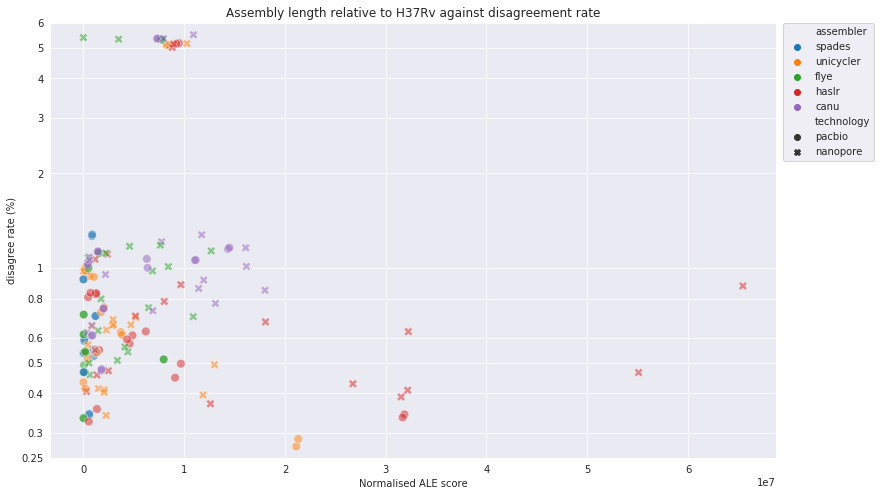

In [201]:
x = "norm_ale_score"
y = "disagree_rate"
hue = "assembler"
style = "technology"
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.scatterplot(
    x=x, 
    y=y, 
    data=df, 
    hue=hue,
    style=style,
    ax=ax,
    s=75,
    alpha=0.5
)
ax.set(title="Assembly length relative to H37Rv against disagreement rate")
_ = ax.set_xlabel("Normalised ALE score")
# ax.set_xscale("log")
ax.set_yscale("log")

log_ticks = [0, 1, 500, 1_000, 5_000, 10_000, 100_000, 500_000, 1_000_000, 10_000_000, 80_000_000]
# ax.set_xticks(log_ticks)
# _ = ax.set_xticklabels(log_ticks)
# _ = ax.set_xlim((log_ticks[0], log_ticks[-1]))
ax.set_ylabel("disagree rate (%)")
log_ticks = [0.25, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 2, 3, 4, 5, 6]
ax.set_yticks(log_ticks)
_ = ax.set_yticklabels(log_ticks)
_ = ax.set_ylim((log_ticks[0], log_ticks[-1]))
# Put the legend out of the figure
_ = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

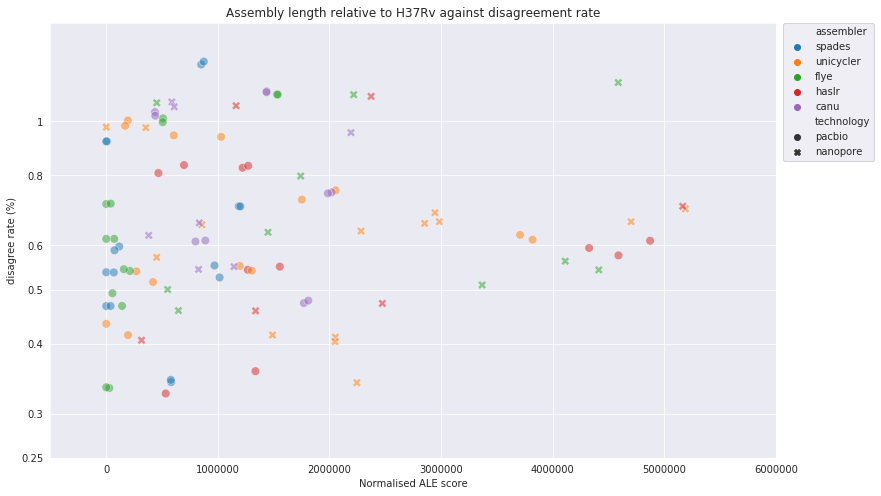

In [209]:
x = "norm_ale_score"
y = "disagree_rate"
hue = "assembler"
style = "technology"
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.scatterplot(
    x=x, 
    y=y, 
    data=df, 
    hue=hue,
    style=style,
    ax=ax,
    s=75,
    alpha=0.5
)
ax.set(title="Assembly length relative to H37Rv against disagreement rate")
_ = ax.set_xlabel("Normalised ALE score")
# ax.set_xscale("log")
ax.set_yscale("log")

log_ticks = [0, 1, 500, 1_000, 5_000, 10_000, 100_000, 500_000, 1_000_000, 10_000_000, 80_000_000]
# ax.set_xticks(log_ticks)
# _ = ax.set_xticklabels(log_ticks)
_ = ax.set_xlim((-5e5, 0.6e7))
ax.set_ylabel("disagree rate (%)")
log_ticks = [0.25, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 2, 3, 4, 5, 6]
ax.set_yticks(log_ticks)
_ = ax.set_yticklabels(log_ticks)
_ = ax.set_ylim((log_ticks[0], 1.5))
# Put the legend out of the figure
_ = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

# Mapping quality statistics
This section will look at the mapping quality scores from the Illumina reads mapped to their respective assemblies.

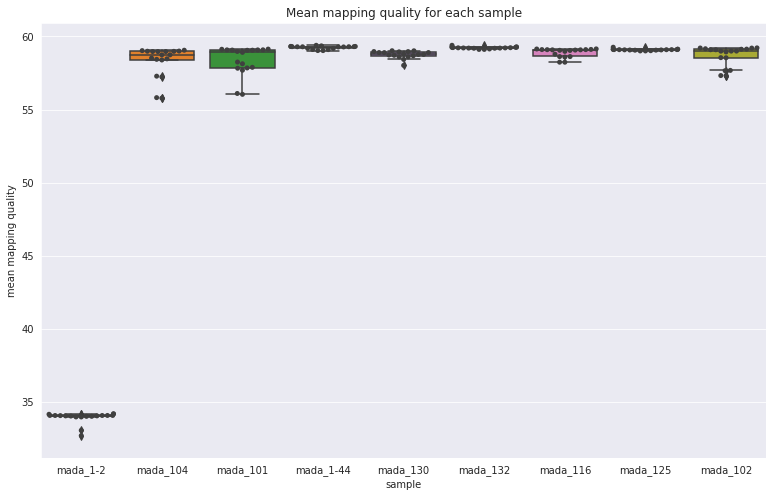

In [167]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x="sample", 
    y="mapq_mean", 
    data=df, 
    ax=ax
)
ax = sns.swarmplot(
    x="sample", 
    y="mapq_mean", 
    data=df, 
    ax=ax,
    dodge=True,
    color="0.25"
)
ax.set(title="Mean mapping quality for each sample")
_ = ax.set_ylabel("mean mapping quality")

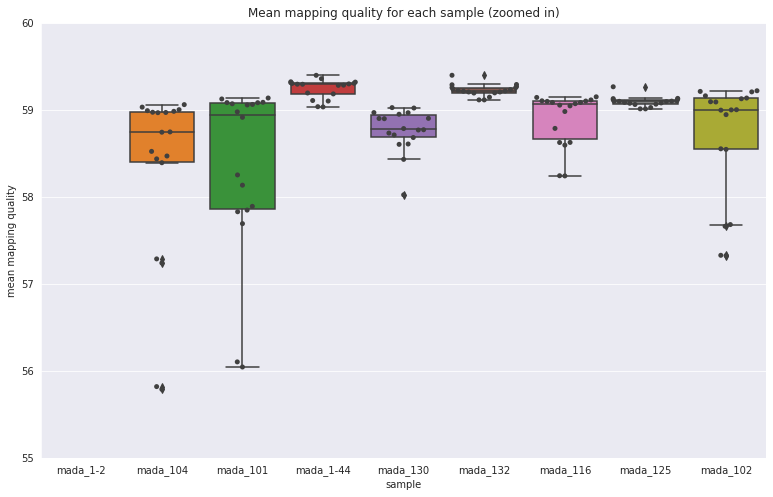

In [168]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x="sample", 
    y="mapq_mean", 
    data=df, 
    ax=ax
)
ax = sns.swarmplot(
    x="sample", 
    y="mapq_mean", 
    data=df, 
    ax=ax,
    dodge=True,
    color="0.25"
)
ax.set(title="Mean mapping quality for each sample (zoomed in)")
_ = ax.set_ylabel("mean mapping quality")
_ = ax.set_ylim((55, 60))

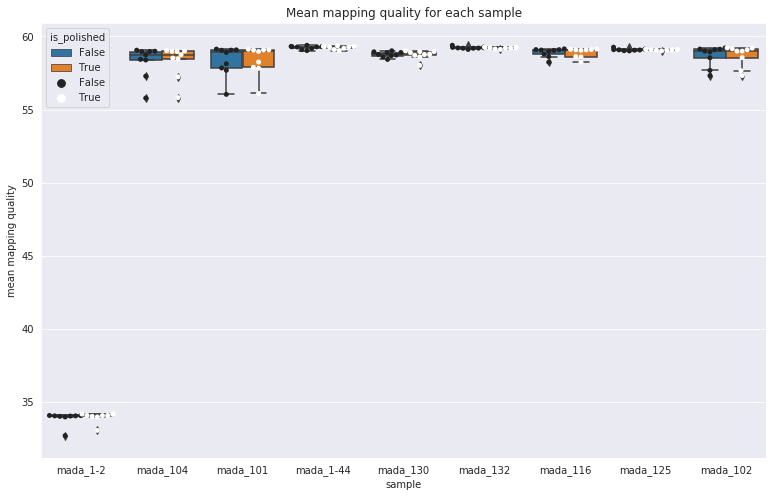

In [169]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x="sample", 
    y="mapq_mean", 
    hue="is_polished",
    data=df, 
    ax=ax
)
ax = sns.swarmplot(
    x="sample", 
    y="mapq_mean", 
    hue="is_polished",
    data=df, 
    ax=ax,
    dodge=True,
    color="white"
)
ax.set(title="Mean mapping quality for each sample")
_ = ax.set_ylabel("mean mapping quality")

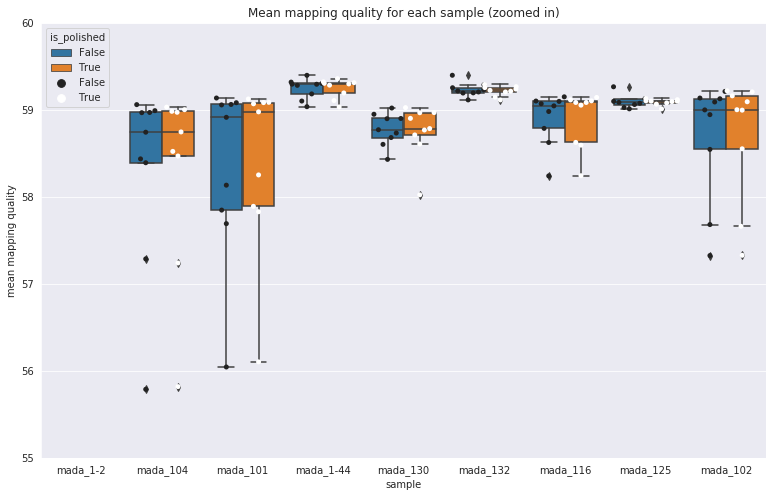

In [170]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x="sample", 
    y="mapq_mean", 
    hue="is_polished",
    data=df, 
    ax=ax
)
ax = sns.swarmplot(
    x="sample", 
    y="mapq_mean", 
    hue="is_polished",
    data=df, 
    ax=ax,
    dodge=True,
    color="white"
)
ax.set(title="Mean mapping quality for each sample (zoomed in)")
_ = ax.set_ylabel("mean mapping quality")
_ = ax.set_ylim((55, 60))

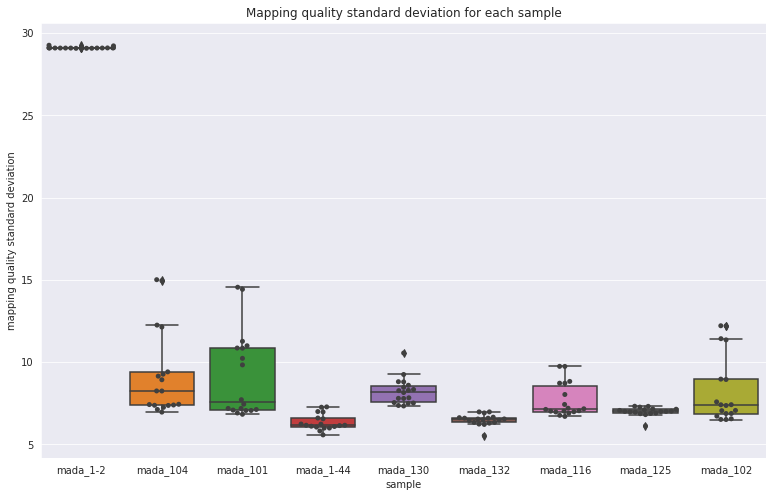

In [171]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x="sample", 
    y="mapq_stdev", 
    data=df, 
    ax=ax
)
ax = sns.swarmplot(
    x="sample", 
    y="mapq_stdev", 
    data=df, 
    ax=ax,
    dodge=True,
    color="0.25"
)
ax.set(title="Mapping quality standard deviation for each sample")
_ = ax.set_ylabel("mapping quality standard deviation")